![OpenDreamKit logo and EU Flag](header.png)

# Micromagnetic standard problem 3

OpenDreamKit review meeting 26 April 2017, Brussels

## Problem specification

This problem is to calculate a single domain limit of a cubic magnetic particle. This is the size $L$ of equal energy for the so-called flower state (which one may also call a splayed state or a modified single-domain state) on the one hand, and the vortex or curling state on the other hand.

Geometry:

A cube with edge length, $L$, expressed in units of the intrinsic length scale, $l_\text{ex} = \sqrt{A/K_\text{m}}$, where $K_\text{m}$ is a magnetostatic energy density, $K_\text{m} = \frac{1}{2}\mu_{0}M_\text{s}^{2}$.

Material parameters: 

- uniaxial anisotropy $K_\text{u}$ with $K_\text{u} = 0.1 K_\text{m}$, and with the easy axis directed parallel to a principal axis of the cube (0, 0, 1),
- exchange energy constant is $A = \frac{1}{2}\mu_{0}M_\text{s}^{2}l_\text{ex}^{2}$.

More details about the standard problem 3 can be found in Ref. 1.

## Simulation

In [1]:
%run ./autoplay.py

In [5]:
import discretisedfield as df
import oommfc as oc
import numpy as np
%matplotlib inline


def m_init_flower(pos):                 
    """Function for initiaising the flower state."""
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = 2*z - 1
    mz = -2*y + 1
    norm_squared = mx**2 + my**2 + mz**2
    if norm_squared <= 0.05:
        return (1, 0, 0)
    else:
        return (mx, my, mz)

def m_init_vortex(pos):
    """Function for initialising the vortex state."""
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = np.sin(np.pi/2 * (x-0.5))
    mz = np.cos(np.pi/2 * (x-0.5))
    return (mx, my, mz)

def minimise_system_energy(L, m_init):
    print("Working on L={} ({})".format(L, m_init.__name__))
    N = 10                      # discretisation in one dimension
    cubesize = 100e-9           # cube edge length (m)
    cellsize = cubesize/N       # discretisation in all three dimensions.
    lex = cubesize/L            # exchange length.
    
    Km = 1e6                    # magnetostatic energy density (J/m**3)
    Ms = np.sqrt(2*Km/oc.mu0)   # magnetisation saturation (A/m)
    A = 0.5 * oc.mu0 * Ms**2 * lex**2  # exchange energy constant
    K = 0.1*Km                  # Uniaxial anisotropy constant
    u = (0, 0, 1)               # Uniaxial anisotropy easy-axis

    p1 = (0, 0, 0)              # Minimum sample coordinate.
    p2 = (cubesize, cubesize, cubesize)  # Maximum sample coordinate.
    cell = (cellsize, cellsize, cellsize)  # Discretisation.
    mesh = oc.Mesh(p1=(0, 0, 0), p2=(cubesize, cubesize, cubesize),
                   cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

    system = oc.System(name="stdprob3")
    system.hamiltonian = oc.Exchange(A) \
                         + oc.UniaxialAnisotropy(K, u) \
                         + oc.Demag()
    system.m = df.Field(mesh, value=m_init, norm=Ms)

    md = oc.MinDriver()         # minimise system energy
    md.drive(system)
    
    return system

### Compute relaxed magnetisation states with one function call

**Vortex** state:

Working on L=8 (m_init_vortex)
2017/4/26 0:16: Calling OOMMF (stdprob3/stdprob3.mif) ... [6.1s]
Total energy is 3.207212348928367e-16J


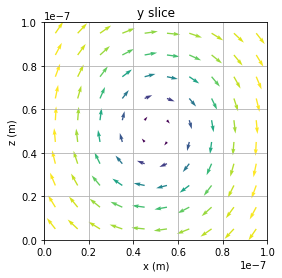

In [7]:
system = minimise_system_energy(8, m_init_vortex)
print("Total energy is {}J".format(system.total_energy()))
system.m.plot_slice('y', 50e-9, xsize=4);

**Flower** state:

In [8]:
system = minimise_system_energy(8, m_init_flower)
print("Total energy is {}J".format(system.total_energy()))
system.m.plot_slice('x', 50e-9, xsize=4);

Working on L=8 (m_init_flower)
2017/4/26 0:16: Calling OOMMF (stdprob3/stdprob3.mif) ... 

KeyboardInterrupt: 

### Compute table and plot for energy crossing

In [ ]:
L_array = np.linspace(8, 9, 4)  # values of L for which 
                                # the system is relaxed.
vortex_energies = []
flower_energies = []

for L in L_array:               # iterate through simulation data points
    vortex = minimise_system_energy(L, m_init_vortex)
    flower = minimise_system_energy(L, m_init_flower)
    
    vortex_energies.append(vortex.total_energy())
    flower_energies.append(flower.total_energy())
    
# Plot the results
import matplotlib.pyplot as plt
plt.plot(L_array, vortex_energies, 'o-', label='vortex')
plt.plot(L_array, flower_energies, 'o-', label='flower')
plt.xlabel('L (lex)')
plt.ylabel('E')
plt.xlim([8.0, 9.0])
plt.grid()
plt.legend()

Working on L=8.0 (m_init_vortex)
2017/4/26 0:16: Calling OOMMF (stdprob3/stdprob3.mif) ... [6.2s]


We now know that the energy crossing occurrs between $8l_\text{ex}$ and $9l_\text{ex}$, so a root finding algorithm can be used to find the exact crossing.

In [ ]:
from scipy.optimize import bisect

def energy_difference(L):
    vortex = minimise_system_energy(L, m_init_vortex)
    flower = minimise_system_energy(L, m_init_flower)
    
    return vortex.total_energy() - flower.total_energy()

xtol = 0.1
cross_section = bisect(energy_difference, 8, 9, xtol=xtol)

print("The transition between vortex and flower states\n" 
      "occurs at {}*lex +-{}".format(cross_section, xtol))

## References
[1] µMAG Site Directory http://www.ctcms.nist.gov/~rdm/mumag.org.html